In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as f
from models import DnCNN, PatchLoss, WeightedPatchLoss
import uproot as up
import numpy as np
import torch.utils.data as udata
import matplotlib.pyplot as plt
import random

In [2]:
def choose_device():
    if torch.cuda.is_available():
        dev = torch.device('cuda')
        print("Using GPU")
    else:
        dev = torch.device('cpu')
        print("Using CPU")
    return dev

def load_model(trained_model, dev):
    model = DnCNN(channels=1, num_of_layers=9, kernel_size=3, features=9).to(device=dev)
    model.load_state_dict(torch.load(trained_model, map_location=torch.device('cpu'))) 
    model.eval()
    return model 

def eval_loaders(plotdata):
    dataset = plotdata
    loader = udata.DataLoader(dataset=plotdata)
    return loader

In [3]:
def get_tree(file_path):
    file = up.open(file_path)
    tree = file["g4SimHits/tree"]
    return tree;

def get_branch(file_paths):
    file_path = file_paths.split(' ')
    branch = []
    for i, elem in enumerate(file_path):
        tree = get_tree(file_path[i])
        events = tree["bin_weights"].array()
        branch = np.concatenate((branch, events))
    return branch;

def get_bin_weights(branch, n, flipx = None, flipy=None, rot=None):
    data = np.zeros((100,100))
    count = 0
    for y in range(100):
        for x in range(100):
            data[99-x][y]=branch[n][count]
            #if (data[99-x][y] != 0):
                #data[99-x][y] = math.log10(data[99-x][y])
            count+=1
    # do random rotation/flips
    if (flipx):
        data = np.fliplr(data)
    if flipy:
        data = np.flipud(data)
    if rot:
        for i in range(rot):
            data = np.rot90(data)
    return data;

def get_flips():
    flipx = random.randint(0, 1)
    flipy = random.randint(0, 1)
    rot = random.randint(0, 3)
    return flipx, flipy, rot

In [4]:
class RootBasic(udata.Dataset):
    allowed_transforms = ["none","normalize","log10"]
    def __init__(self, fuzzy_root, sharp_root, transform='none'):
        self.sharp_root = sharp_root
        self.fuzzy_root = fuzzy_root
        self.sharp_branch = get_branch(sharp_root)
        self.fuzzy_branch = get_branch(fuzzy_root)
        self.sharp_tree = get_tree(self.sharp_root)
        self.fuzzy_tree = get_tree(self.fuzzy_root)
        self.transform = transform
        self.means = None
        self.stdevs = None
        if self.transform not in self.allowed_transforms:
            raise ValueError("Unknown transform: {}".format(self.transform))

    def __len__(self):
        if len(self.sharp_branch) == len(self.fuzzy_branch):
            return len(self.sharp_branch)
        else:
            raise RuntimeError("Sharp and fuzzy dataset lengths do not match")
            
    def __getitem__(self, idx):
        flipx, flipy, rot = get_flips()
        sharp_np = get_bin_weights(self.sharp_branch, idx, flipx, flipy, rot).copy()
        fuzzy_np = get_bin_weights(self.fuzzy_branch, idx, flipx, flipy, rot).copy()
        return sharp_np, fuzzy_np
    
    #can only be called after __getitem__ has run in RootDataset
    def unnormalize(self,array):
        array *= self.stdevs
        array += self.means 
        return array

class RootDataset(RootBasic):
    def __getitem__(self, idx):
        sharp_np, fuzzy_np = super().__getitem__(idx)
                    
        if self.transform=="log10":
            sharp_np = np.log10(sharp_np, where=sharp_np>0)
            fuzzy_np = np.log10(fuzzy_np, where=fuzzy_np>0)
        elif self.transform=="normalize":
            self.means = np.mean(sharp_np)
            self.stdevs = np.std(sharp_np)
            sharp_np -= self.means
            sharp_np /= self.stdevs
            fuzzy_np -= self.means
            fuzzy_np /= self.stdevs
        
        sharp = torch.from_numpy(sharp_np)
        fuzzy = torch.from_numpy(fuzzy_np)
        return sharp, fuzzy 

In [5]:
def make_sample_images(fuzzy_root, sharp_root, model, transform='none'):
    branch_arrays = RootBasic(fuzzy_root, sharp_root, transform)
    dataset = RootDataset(fuzzy_root, sharp_root, transform)
    model.to('cpu')
    #random.seed(args.randomseed) #makes random orientations match those from training
    for event in range(10):
        #flipx, flipy, rot = get_flips()
        sharp, fuzzy = branch_arrays[event]
        sharp_norm, fuzzy_norm = dataset[event]
        fuzzy_eval = fuzzy_norm.unsqueeze(0).unsqueeze(1)
        output = model(fuzzy_eval.float()).squeeze(0).squeeze(0).cpu().detach().numpy()
        output_un = dataset.unnormalize(output)
    #model.to('cuda')
    return output_un

In [6]:
def get_output(dataset, event):
    #dataset = RootDataset(fuzzy_root, sharp_root, transform)
    model.to('cpu')
    #random.seed(args.randomseed) #makes random orientations match those from training
    #flipx, flipy, rot = get_flips()
    #sharp, fuzzy = branch_arrays[event]
    sharp_norm, fuzzy_norm = dataset[event]
    fuzzy_eval = fuzzy_norm.unsqueeze(0).unsqueeze(1)
    output = model(fuzzy_eval.float()).squeeze(0).squeeze(0).cpu().detach().numpy()
    output_un = dataset.unnormalize(output)
    #model.to('cuda')
    return output_un

In [7]:
# def calculate_ppe(event, eventtype):
#     if eventtype == 'fuzzy':
#         sharp, fuzzy = event
#         pixel_energies = get_output()
#         energy_per_pixel = np.mean(pixel_energies)
#     if eventtype == 'sharp':
#         pixel_energies = event
#         energy_per_pixel = np.mean(pixel_energies)
#     return energy_per_pixel

# def ppe_data(dataset, eventtype):
#     per_pixel_energy = []
#     for i, elem in enumerate(dataset):
#         event = calculate_ppe(dataset[i], eventtype)
#         per_pixel_energy.append(event)
#     return per_pixel_energy

def calculate_ppe(dataset, basic_dataset, event):
    ppe = []
    sharp, fuzzy = basic_dataset[event]
    sharp_energies = np.ndarray.flatten(sharp)
    fuzzy_energies = np.ndarray.flatten(fuzzy)
    ppe_sharp = np.mean(sharp_energies)
    ppe_fuzzy = np.mean(fuzzy_energies)
    output = get_output(dataset, event)
    ppe_output = np.mean(output)
    ppe.append(ppe_sharp)
    ppe.append(ppe_fuzzy)
    ppe.append(ppe_output)
    return ppe
    
def ppe_plotdata(dataset, basic_dataset):
    ppe_sharp = []
    ppe_fuzzy = []
    ppe_output = []
    for i in range(len(basic_dataset)):
        ppes = calculate_ppe(dataset, basic_dataset, i)
        sharp_ppe = ppes[0]
        fuzzy_ppe = ppes[1]
        output_ppe = ppes[2]
        ppe_sharp.append(sharp_ppe)
        ppe_fuzzy.append(fuzzy_ppe)
        ppe_output.append(output_ppe)
    return ppe_sharp, ppe_fuzzy, ppe_output

def centroid(dataset, basic_dataset, event, event_type):
    if event_type == 'output':
        event_points = []
        output = get_output(dataset,event)
        y_avg = 0
        for y in range(100):
            y_en = y*np.mean(output[y])
            y_avg += y_en
        y_avg = y_avg/100
        x_avg = 0
        for x in range(100):
            for y in range(100):
                x_en = x*output[y][x]
                x_avg += x_en
        x_avg = (x_avg/100)/100
    if event_type == 'fuzzy':
        event_points = []
        sharp, fuzzy = basic_dataset[event]
        y_avg = 0
        for y in range(100):
            y_en = y*np.mean(fuzzy[y])
            y_avg += y_en
        y_avg = y_avg/100
        x_avg = 0
        for x in range(100):
            for y in range(100):
                x_en = x*fuzzy[y][x]
                x_avg += x_en
        x_avg = (x_avg/100)/100
    if event_type == 'sharp':
        event_points = []
        sharp, fuzzy = basic_dataset[event]
        y_avg = 0
        for y in range(100):
            y_en = y*np.mean(sharp[y])
            y_avg += y_en
        y_avg = y_avg/100
        x_avg = 0
        for x in range(100):
            for y in range(100):
                x_en = x*sharp[y][x]
                x_avg += x_en
        x_avg = (x_avg/100)/100
    return x_avg, y_avg
            
def centroid_plotdata(dataset, basic_dataset, event_type, ppe_plot):
    centroids = []
    centroids_x = []
    centroids_y = []
    for i in range(len(basic_dataset)):
        cntr = centroid(dataset, basic_dataset, i, event_type)
        if event_type == 'sharp': j=0 
        if event_type == 'fuzzy': j=1
        if event_type == 'output': j=2
        cntr_x = cntr[0]/(ppe_plot[j][i])
        cntr_y = cntr[1]/(ppe_plot[j][i])
        centroids_x.append(cntr_x)
        centroids_y.append(cntr_y)
    centroids.append(centroids_x)
    centroids.append(centroids_y)
    return centroids

def centroid_rad_data(centroid_plotdata):
    centroid_rads = []
    for i in range(len(centroid_plotdata[0])):
        centroid_rad = np.sqrt(centroid_plotdata[0][i]**2+centroid_plotdata[1][i]**2)
        centroid_rads.append(centroid_rad)
    return centroid_rads

def hits_above_threshold(dataset, basic_dataset, threshold, event, event_type):
    if event_type == 'sharp' or 'fuzzy':
        sharp, fuzzy = basic_dataset[event]
    count = 0
    if event_type == 'sharp':
        for y in range(100):
            for x in range(100):
                if sharp[y][x] >= threshold:
                    count +=1
    if event_type == 'fuzzy':
        for y in range(100):
            for x in range(100):
                if fuzzy[y][x] >= threshold:
                    count +=1
    if event_type == 'output':
        output = get_output(dataset, event)
        for y in range(100):
            for x in range(100):
                if output[y][x] >= threshold:
                    count +=1
    return count

def hits_data(dataset, basic_dataset, threshold, event_type):
    hits = []
    for i in range(len(basic_dataset)):
        hit = hits_above_threshold(dataset, basic_dataset, threshold, i, event_type)
        hits.append(hit)
    return hits

#def hits_data(dataset, basic_dataset, threshold, event_type):

def diff(dataset1, dataset2):
    diffset = []
    for i, elem in enumerate(dataset1):
        diff = dataset1[i] - dataset2[i]
        diffset.append(diff)
    return diffset
        
    

In [8]:
def plot(ll):
    plt.hist(ppe_data)
    plt.show()

In [9]:
device = choose_device()
#loader = eval_loaders(data)
model = load_model('out-train-jul30-1/net.pth', device)
#make_sample_images('ntup_photon_energy700.0_mult1_eta0.5_phi0.0_ProductionCut10.0_n20.root','ntup_photon_energy700.0_mult1_eta0.5_phi0.0_n20.root', model, 'normalize')

Using CPU


In [10]:
dataset = RootDataset('ntup_photon_energy700.0_mult1_eta0.5_phi0.0_ProductionCut10.0_n20.root','ntup_photon_energy700.0_mult1_eta0.5_phi0.0_n20.root', 'normalize')

In [51]:
data = get_output(dataset, 9)

In [52]:
len(data)

100

In [11]:
basic_dataset = RootBasic('ntup_photon_energy700.0_mult1_eta0.5_phi0.0_ProductionCut10.0_n20.root','ntup_photon_energy700.0_mult1_eta0.5_phi0.0_n20.root', 'normalize')

In [54]:
calculate_ppe(dataset, basic_dataset, 9)

[46.07495323465802, 66.23541615071841, 39.591766]

In [55]:
plot_data = ppe_plotdata(dataset, basic_dataset)

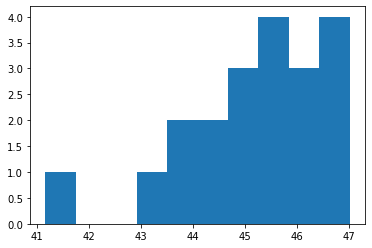

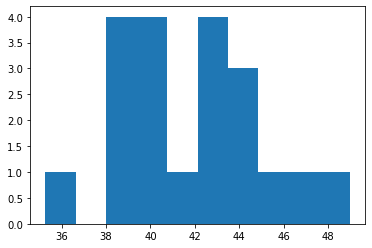

In [56]:
sharp, fuzzy, output = plot_data
    
plot(sharp)
plot(output)

In [83]:
plot_data;

In [85]:
basic_dataset[1][1];

In [84]:
len(basic_dataset[1][1][1]);

In [60]:
sharp_centroid = centroid_plotdata(dataset, basic_dataset, 'sharp', plot_data)

In [61]:
fuzzy_centroid = centroid_plotdata(dataset, basic_dataset, 'fuzzy', plot_data)

In [62]:
output_centroid = centroid_plotdata(dataset, basic_dataset, 'output', plot_data)

In [63]:
#centroid_plotdata(dataset, basic_dataset, 'fuzzy')

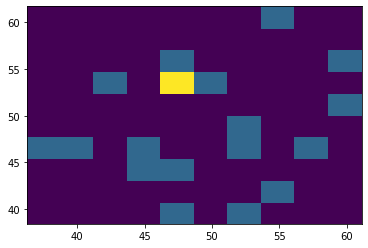

In [64]:
plt.hist2d(sharp_centroid[0], sharp_centroid[1],  bins=10)
plt.show()

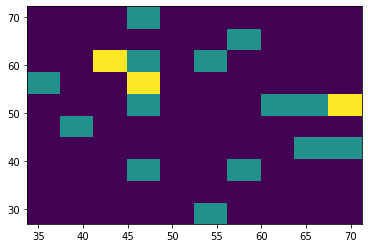

In [86]:
plt.hist2d(fuzzy_centroid[0], fuzzy_centroid[1],  bins=10)
plt.show()

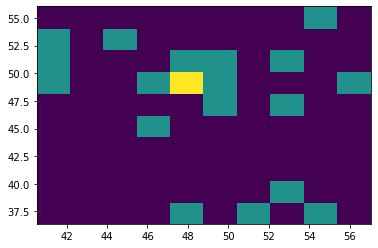

In [87]:
plt.hist2d(output_centroid[0], output_centroid[1],  bins=10)
plt.show()

In [88]:
sharp_centroid[0];

In [89]:
sharp_centroid[1];

In [69]:
centroid_rad_plot_sharp = centroid_rad_data(sharp_centroid);

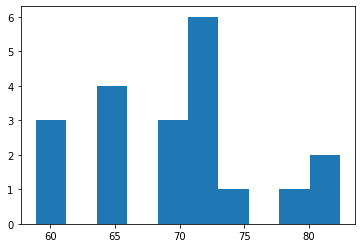

In [90]:
plt.hist(centroid_rad_plot_sharp)
plt.show()

In [71]:
centroid_rad_plot_fuzzy = centroid_rad_data(fuzzy_centroid)
centroid_rad_plot_output = centroid_rad_data(output_centroid)

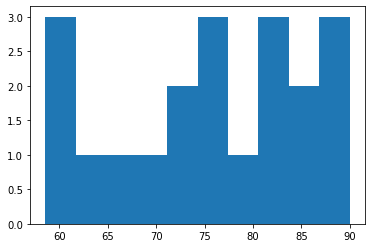

In [91]:
plt.hist(centroid_rad_plot_fuzzy)
plt.show()

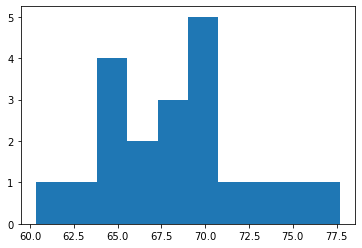

In [92]:
plt.hist(centroid_rad_plot_output)
plt.show()

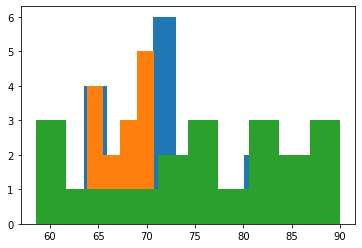

In [93]:
plt.hist(centroid_rad_plot_sharp)
plt.hist(centroid_rad_plot_output)
plt.hist(centroid_rad_plot_fuzzy)
plt.show()

In [12]:
sharp_hits = hits_data(dataset, basic_dataset, 0.1, 'sharp')

In [13]:
fuzzy_hits = hits_data(dataset, basic_dataset, 0.1, 'fuzzy')

In [14]:
output_hits = hits_data(dataset, basic_dataset, 0.1, 'output')

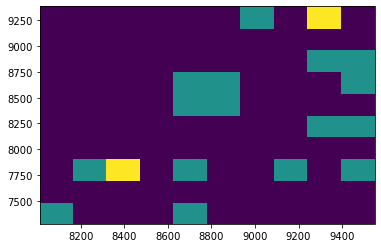

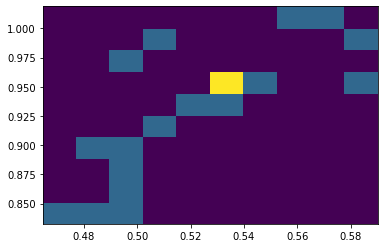

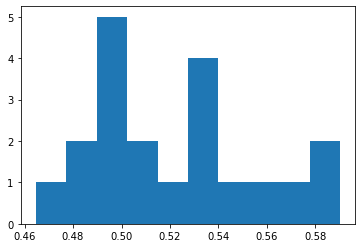

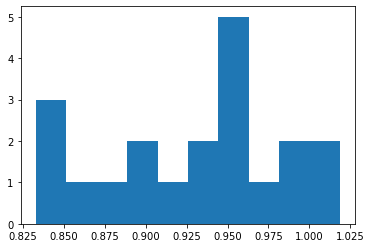

In [23]:
plt.hist2d(sharp_hits, output_hits,  bins=10)
plt.show()

plt.hist2d(np.divide(fuzzy_hits, sharp_hits),np.divide(output_hits,sharp_hits))
plt.show()

plot(np.divide(fuzzy_hits, sharp_hits))

plot(np.divide(output_hits,sharp_hits))

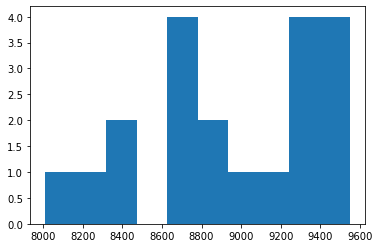

In [94]:
plt.hist(sharp_hits)
plt.show()

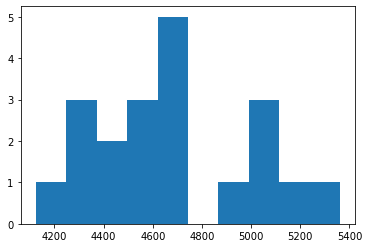

In [95]:
plt.hist(fuzzy_hits)
plt.show()

In [80]:
diff_x = diff(sharp_centroid[0], fuzzy_centroid[0])

In [81]:
diff_y = diff(sharp_centroid[1], fuzzy_centroid[1])

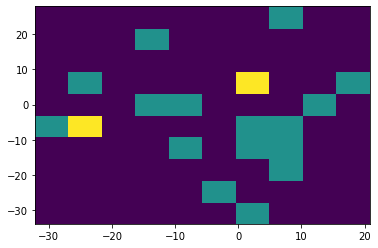

In [96]:
plt.hist2d(diff_x,diff_y)
plt.show()

In [17]:
a= [1,2,3]
b= [2,4,9]
np.divide(a,b)

array([0.5       , 0.5       , 0.33333333])